# Cats and dog recognition using pytorch

This notebook aim at selecting an AI algorithm for cats and dogs classification. That Project has been realized during the advanced AI course at ISEN by pierre louis, adélie, mathis and gael

### data loading and import

In the first part of that notebook, we will import libraries and data.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torchvision import models
from torchvision.io import read_image
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import os
import statistics
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import h5py

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


<p>device set up, using gpu or cpu</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/My Drive/dataset.zip'
!cp path .
!unzip -q '/content/drive/My Drive/dataset.zip'
!rm dataset.zip

cp: cannot stat 'path': No such file or directory
rm: cannot remove 'dataset.zip': No such file or directory


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import train data from the dataset

In [ ]:
train_path = '/content/train/train/'
image_file_path = np.array([train_path + i for i in os.listdir(train_path)])
labels = np.array([
    0 if name.split('/')[-1].startswith('cat') else 1
    for name in image_file_path
])
print(len(image_file_path),len(labels))

25000 25000


In [ ]:
# show result
image_file_path[10:], labels[10:]

(array(['/content/train/train/cat.12105.jpg',
        '/content/train/train/cat.11524.jpg',
        '/content/train/train/cat.8738.jpg', ...,
        '/content/train/train/cat.33.jpg',
        '/content/train/train/dog.4095.jpg',
        '/content/train/train/dog.12104.jpg'], dtype='<U34'),
 array([0, 0, 0, ..., 0, 1, 1]))

In [ ]:
#image=np.array([*image_file_path[:2000],*image_file_path[23000:]])
image=image_file_path
#lab=np.array([*labels[:2000],*labels[23000:]])
lab=labels

In [ ]:
print(image)


['/content/train/train/cat.169.jpg' '/content/train/train/cat.10418.jpg'
 '/content/train/train/cat.7727.jpg' ... '/content/train/train/cat.33.jpg'
 '/content/train/train/dog.4095.jpg' '/content/train/train/dog.12104.jpg']


split the data into train and validation dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, y_val = train_test_split(image, lab, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_val))

20000


Define how to load the dataset, can be with or without transform. (preprocessing)

In [ ]:
class MyData(Dataset):
    def __init__(self, data_path, labels=None, transform=None):
        self.data_path = data_path
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = read_image(self.data_path[index]) # [channel,height,width]
        image = image.to(torch.float32) / 255.
        if self.transform is not None:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[index]
        return image

    def __len__(self):
        return self.data_path.shape[0]


In [ ]:
batch_size = 32

<p> Transform without any data augmentation </p>

In [ ]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

<p>Load image</p>

In [ ]:
ds1 = MyData(X_train, y_train, transform)
ds2 = MyData(x_val, y_val, transform)


train_ds = DataLoader(ds1, batch_size=batch_size, shuffle=True)
val_ds = DataLoader(ds2, batch_size=batch_size, shuffle=True)

## From Scratch model

In this part we will create a model with 3 convolutional layers and train him. We will also define our train and evaluate function that we'll use during the notebook.

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def flatten(x):
    return x.view(x.shape[0], -1)

Train and evaluation function for pytorch model

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def train(model, epoch, train_ds):
    model.train()
    total_num = len(train_ds.dataset)
    train_loss = 0
    correct_num = 0
    auclist=[]
    for image, label in train_ds:
        # load data on the device (gpu or cpu)
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        #get the model prediction
        output = model(image)
        #calculate the loss
        loss = criterion(output, label)
        train_loss += loss.item() * label.size(0)
        optimizer.zero_grad()
        loss.backward()
        # use the optimizer to train
        optimizer.step()
        
        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()
        #auc metrics calculation
        auc=roc_auc_score(label.cpu().detach().numpy(),predict.cpu().detach().numpy())
        auclist.append(auc)
    #calculate the loss
    train_loss = train_loss / total_num
    #calculate the accuracy
    train_acc = correct_num / total_num
    print('epoch: {} --> train_loss: {:.6f} - train_acc: {:.6f} - '.format(
        epoch, train_loss, train_acc), end='')
    return train_loss,train_acc,auclist

def evaluate(model, eval_ds, mode='val'):
    #evaluation fonction
    model.eval()

    total_num = len(eval_ds.dataset)
    eval_loss = 0
    correct_num = 0
    auclist=[]

    for image, label in eval_ds:
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        # get the prediction
        output = model(image)
        loss = criterion(output, label)
        eval_loss += loss.item() * label.size(0)
        # calculate the accuracy
        predict = torch.argmax(output, dim=-1)
        #number of good response
        correct_num += label.eq(predict).sum()
        auc=roc_auc_score(label.cpu().detach().numpy(),predict.cpu().detach().numpy())
        auclist.append(auc)

    eval_loss = eval_loss / total_num
    eval_acc = correct_num / total_num
    
    print('{}_loss: {:.6f} - {}_acc: {:.6f}'.format(
        mode, eval_loss, mode, eval_acc))
    return eval_loss,eval_acc,auclist

We then Define our model, We choose a basic model composed of 3 convolutional layers and 2 linear output layers to do our testing

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,128,kernel_size=(3,3))
        self.drop1 = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(128,64,kernel_size=(3,3))
        self.drop2 = nn.Dropout(0.3)
        self.conv3 = nn.Conv2d(64,32,kernel_size=(3,3))
        self.drop2 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(32*30*30,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        x= self.pool(F.relu(self.conv1(x)))
        x=self.drop1(x)
        
        x=self.pool(F.relu(self.conv2(x)))
        x=self.drop2(x)
        
        x=self.pool(F.relu(self.conv3(x)))
        x=self.drop2(x)
        
        x= x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=torch.sigmoid(self.fc2(x))
        return x

In [ ]:
model=Model()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = F.cross_entropy
Tloss=[]
Tacc=[]
Tauc=[]
Vloss=[]
Vacc=[]
Vauc=[]
for epoch in range(15):
    train_loss,train_acc,train_auc=train(model, epoch, train_ds)
    Tloss.append(train_loss)
    Tauc.append(train_auc)
    Tacc.append(train_acc)
    val_loss,val_acc,val_auc=evaluate(model, val_ds)
    Vloss.append(val_loss)
    Vacc.append(val_acc)
    Vauc.append(val_auc)

epoch: 0 --> train_loss: 0.693669 - train_acc: 0.486786 - val_loss: 0.693006 - val_acc: 0.495833
epoch: 1 --> train_loss: 0.692387 - train_acc: 0.494286 - val_loss: 0.690922 - val_acc: 0.495833
epoch: 2 --> train_loss: 0.689902 - train_acc: 0.500714 - val_loss: 0.686504 - val_acc: 0.589167
epoch: 3 --> train_loss: 0.679768 - train_acc: 0.588214 - val_loss: 0.674066 - val_acc: 0.604167
epoch: 4 --> train_loss: 0.669192 - train_acc: 0.608929 - val_loss: 0.667463 - val_acc: 0.610833
epoch: 5 --> train_loss: 0.662693 - train_acc: 0.620714 - val_loss: 0.662389 - val_acc: 0.636667
epoch: 6 --> train_loss: 0.653062 - train_acc: 0.633929 - val_loss: 0.651215 - val_acc: 0.644167
epoch: 7 --> train_loss: 0.644613 - train_acc: 0.659286 - val_loss: 0.644577 - val_acc: 0.653333
epoch: 8 --> train_loss: 0.630629 - train_acc: 0.681071 - val_loss: 0.636687 - val_acc: 0.660833
epoch: 9 --> train_loss: 0.619041 - train_acc: 0.682500 - val_loss: 0.636936 - val_acc: 0.657500
epoch: 10 --> train_loss: 0.60

#evaluation and metrics analysis

Now that our model has been trained, we need to evaluate him using several metrics, we choose AUC, accuracy and loss.

**auc evolution per epoch**

In [ ]:
meanper_epo=[]
for epo in metricsauc:
  meanper_epo.append(statistics.mean(epo))

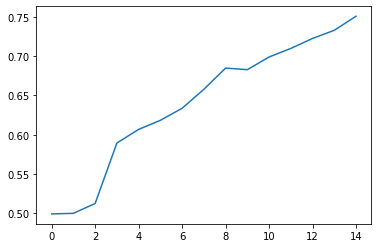

In [ ]:
plt.plot(np.arange(start=0, stop=len(meanper_epo), step=1),meanper_epo)

the auc score is going up as expected for a normal training.

**loss evolution per epoch**

train data

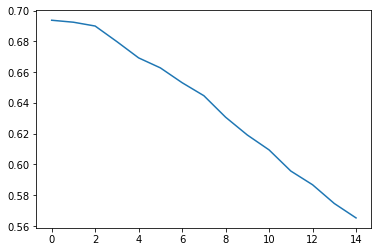

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tloss), step=1),Tloss)

validation data

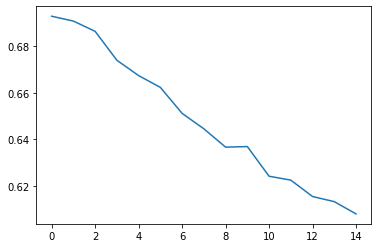

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vloss), step=1),Vloss)

**acc evolution per epoch**

train data

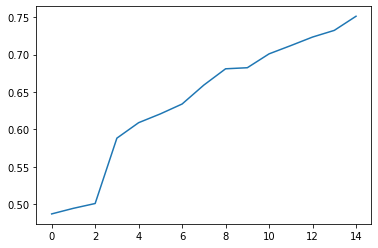

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tacc), step=1),Tacc)

validation data

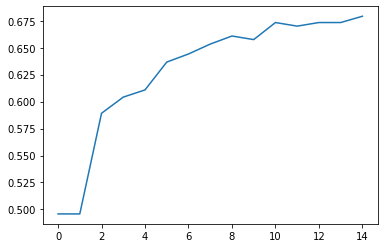

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vacc), step=1),Vacc)

Finally, our model is training properly. Although we can see that our accuracy is stagnating after 10/12 epoch at 70% on our validation data.
To try to have better result we will than run test with a fine tune resnet model

## using resnet as base model





We will now use resnet pre trained model as a base line for our model and fine tune it by changing the output layer weight.


In [ ]:
model_resnet=models.resnet50(pretrained=True)
print(model_resnet)
print(model_resnet.fc.in_features) #print the dimension of the output layer of resnet


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# change the resnet model output layer
model = models.resnet50(pretrained=True)
in_features = model.fc.in_features  # Gets the input dimension of the top output layer
model.fc = nn.Linear(in_features, 2)  # Replace the output layer with the one you need, and the output dimension is 2
model.add_module('softmax', nn.Softmax(dim=-1)) # add a softmax layer
model=model.to(device)

In [ ]:
# Freeze the parameters of other layers except the top layer
for name, m in model.named_parameters():
    if name.split('.')[0] != 'fc':
        m.requires_grad_(False)

In [ ]:
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy
Tloss=[]
Tacc=[]
Tauc=[]
Vloss=[]
Vacc=[]
Vauc=[]
for epoch in range(15):
    train_loss,train_acc,train_auc=train(model, epoch, train_ds)
    Tloss.append(train_loss)
    Tauc.append(train_auc)
    Tacc.append(train_acc)
    val_loss,val_acc,val_auc=evaluate(model, val_ds)
    Vloss.append(val_loss)
    Vacc.append(val_acc)
    Vauc.append(val_auc)

epoch: 0 --> train_loss: 0.172365 - train_acc: 0.947143 - val_loss: 0.119561 - val_acc: 0.956667
epoch: 1 --> train_loss: 0.083214 - train_acc: 0.971429 - val_loss: 0.057217 - val_acc: 0.978333
epoch: 2 --> train_loss: 0.088595 - train_acc: 0.966071 - val_loss: 0.077424 - val_acc: 0.970000
epoch: 3 --> train_loss: 0.060604 - train_acc: 0.977143 - val_loss: 0.038095 - val_acc: 0.985833
epoch: 4 --> train_loss: 0.062667 - train_acc: 0.975000 - val_loss: 0.054684 - val_acc: 0.979167
epoch: 5 --> train_loss: 0.056422 - train_acc: 0.978571 - val_loss: 0.043988 - val_acc: 0.981667
epoch: 6 --> train_loss: 0.045985 - train_acc: 0.983929 - val_loss: 0.035305 - val_acc: 0.985833
epoch: 7 --> train_loss: 0.049795 - train_acc: 0.981071 - val_loss: 0.041182 - val_acc: 0.982500
epoch: 8 --> train_loss: 0.053000 - train_acc: 0.978214 - val_loss: 0.032904 - val_acc: 0.986667
epoch: 9 --> train_loss: 0.036093 - train_acc: 0.986071 - val_loss: 0.035872 - val_acc: 0.985833
epoch: 10 --> train_loss: 0.03

### Resnet evaluation

**auc evolution per epoch**

In [ ]:
meanper_epo=[]
for epo in metricsauc:
  meanper_epo.append(statistics.mean(epo))

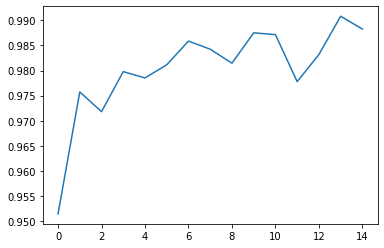

In [ ]:
plt.plot(np.arange(start=0, stop=len(meanper_epo), step=1),meanper_epo)

**loss evolution per epoch**

train data

In [ ]:
print(Tloss)

[0.17236540189811161, 0.08321359372564724, 0.08859535049114908, 0.06060415281248944, 0.06266699878765004, 0.05642238924545901, 0.045984675242964713, 0.04979462088085711, 0.053000219184905294, 0.03609250474455101, 0.03968150480783411, 0.07610583599390729, 0.05078699724016977, 0.03298911031468638, 0.041449220248364976]


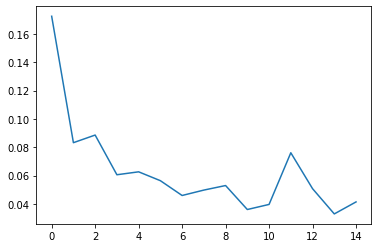

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tloss), step=1),Tloss)

validation data

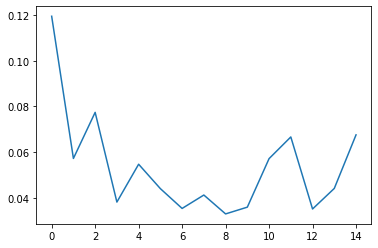

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vloss), step=1),Vloss)

**acc evolution per epoch**

train data

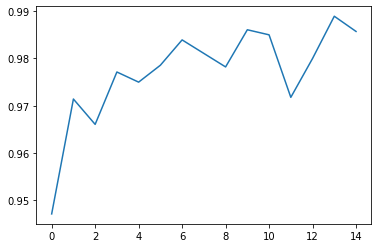

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tacc), step=1),Tacc)

validation data

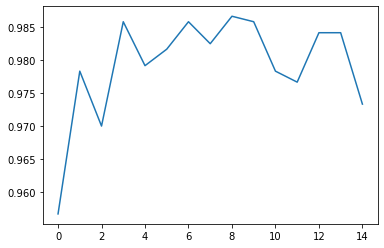

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vacc), step=1),Vacc)

We can see that our resnet model is following the same trend as our previous model, except that his metrics are way better than our self-made model.
It also requires a very few epoch to be really accurate.
After one epoch of training our model is already close to 97% accurate on our validation data

#Saving our resnet model for API implementation


The next step of our research cycle is to implement that model in a "production" environment. For that we will create a web api that can predict if your picture is a dog or a cat.

For that we need to save our model in a pickle format using torch.save

In [ ]:
import pickle

In [ ]:
with open('/content/model_resnet.pkl', 'wb') as f1:
    pickle.dump(model, f1)

In [ ]:
torch.save(model.state_dict(),"/content/model")

## Different Data augmentation test

Another test that we haven't run and that can be very useful in image classification is data augmentation.

We will transform the image to create more data from our dataset.

We choose to analyse the result with the accuracy metrics.

We also choose to run those tests on our self-made model since the resnet model is showing very little improvement after a few epochs.

##First We used a random crop of our image

In [ ]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomCrop(200, padding=4),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Resize([256, 256]),
])

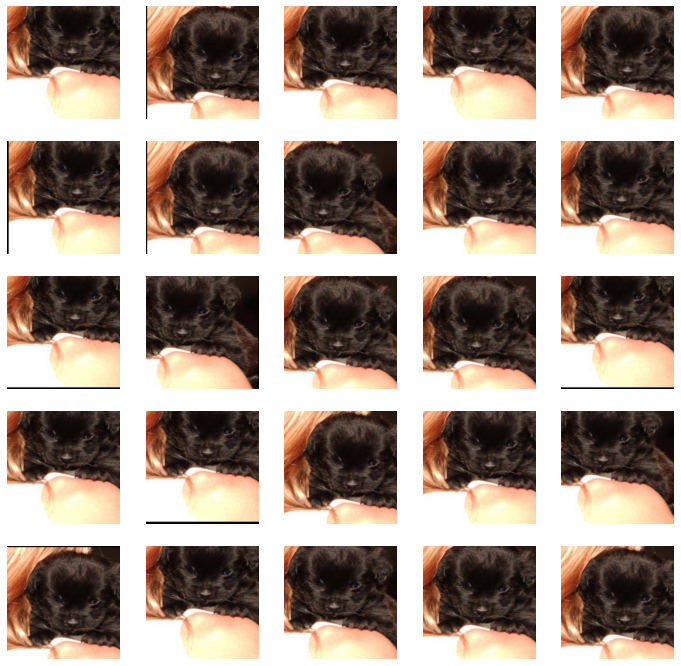

In [ ]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
ds1 = MyData(X_train, y_train, transform)
ds2 = MyData(x_val, y_val, transform)


train_ds = DataLoader(ds1, batch_size=batch_size, shuffle=True)
val_ds = DataLoader(ds2, batch_size=batch_size, shuffle=True)

In [ ]:
# different network
model=Model()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = F.cross_entropy
Tloss=[]
Tacc=[]
Tauc=[]
Vloss=[]
Vacc=[]
Vauc=[]
for epoch in range(5):
    train_loss,train_acc,train_auc=train(model, epoch, train_ds)
    Tloss.append(train_loss)
    Tauc.append(train_auc)
    Tacc.append(train_acc)
    val_loss,val_acc,val_auc=evaluate(model, val_ds)
    Vloss.append(val_loss)
    Vacc.append(val_acc)
    Vauc.append(val_auc)

epoch: 0 --> train_loss: 0.669272 - train_acc: 0.587700 - val_loss: 0.650807 - val_acc: 0.618000
epoch: 1 --> train_loss: 0.625030 - train_acc: 0.658450 - val_loss: 0.614611 - val_acc: 0.671600
epoch: 2 --> train_loss: 0.607172 - train_acc: 0.678850 - val_loss: 0.606619 - val_acc: 0.674000
epoch: 3 --> train_loss: 0.599240 - train_acc: 0.686900 - val_loss: 0.600521 - val_acc: 0.685800
epoch: 4 --> train_loss: 0.591785 - train_acc: 0.695550 - val_loss: 0.598815 - val_acc: 0.682000


**acc evolution per epoch**

train data

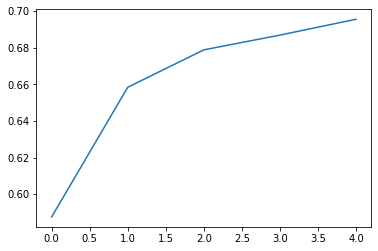

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tacc), step=1),Tacc)

validation data

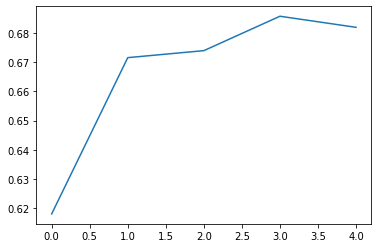

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vacc), step=1),Vacc)

We can see that our accuracy is slightly higher and that the training takes fewer epochs. The final value of accuracy is still around 70% on the validation data.

# random horizontal flip

In [ ]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([256, 256]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    
])

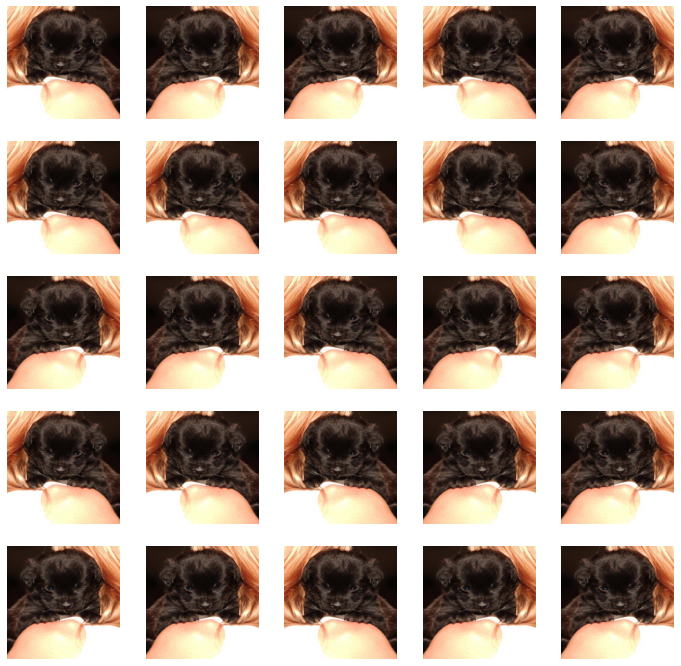

In [ ]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
ds1 = MyData(X_train, y_train, transform)
ds2 = MyData(x_val, y_val, transform)


train_ds = DataLoader(ds1, batch_size=batch_size, shuffle=True)
val_ds = DataLoader(ds2, batch_size=batch_size, shuffle=True)

In [ ]:
model=Model()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy
Tloss=[]
Tacc=[]
Tauc=[]
Vloss=[]
Vacc=[]
Vauc=[]
for epoch in range(5
):
    train_loss,train_acc,train_auc=train(model, epoch, train_ds)
    Tloss.append(train_loss)
    Tauc.append(train_auc)
    Tacc.append(train_acc)
    val_loss,val_acc,val_auc=evaluate(model, val_ds)
    Vloss.append(val_loss)
    Vacc.append(val_acc)
    Vauc.append(val_auc)

**acc evolution per epoch**

train data

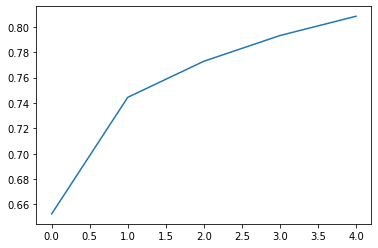

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tacc), step=1),Tacc)

validation data

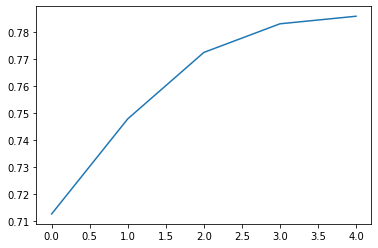

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vacc), step=1),Vacc)

With this transformation the result is better, the accuracy is getting higher way faster and is around 80% at the end of the 5th epoch.

# Add perspective to the image

In [ ]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomPerspective(),
    transforms.Resize([256, 256]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

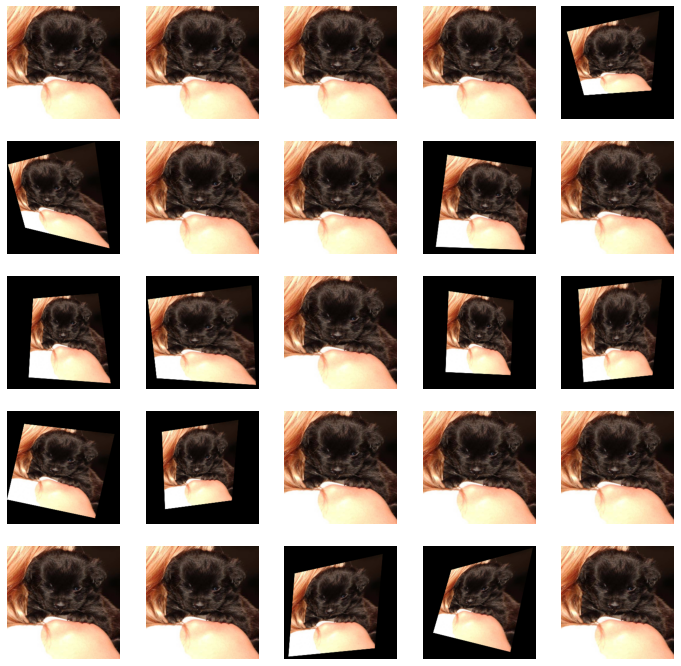

In [ ]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
ds1 = MyData(X_train, y_train, transform)
ds2 = MyData(x_val, y_val, transform)


train_ds = DataLoader(ds1, batch_size=batch_size, shuffle=True)
val_ds = DataLoader(ds2, batch_size=batch_size, shuffle=True)

In [ ]:
model=Model()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy
Tloss=[]
Tacc=[]
Tauc=[]
Vloss=[]
Vacc=[]
Vauc=[]
for epoch in range(5):
    train_loss,train_acc,train_auc=train(model, epoch, train_ds)
    Tloss.append(train_loss)
    Tauc.append(train_auc)
    Tacc.append(train_acc)
    val_loss,val_acc,val_auc=evaluate(model, val_ds)
    Vloss.append(val_loss)
    Vacc.append(val_acc)
    Vauc.append(val_auc)

epoch: 0 --> train_loss: 0.693387 - train_acc: 0.500250 - val_loss: 0.693147 - val_acc: 0.506400
epoch: 1 --> train_loss: 0.693147 - train_acc: 0.499050 - val_loss: 0.693147 - val_acc: 0.505800
epoch: 2 --> train_loss: 0.693153 - train_acc: 0.495700 - val_loss: 0.693147 - val_acc: 0.491600
epoch: 3 --> train_loss: 0.693147 - train_acc: 0.492000 - val_loss: 0.693147 - val_acc: 0.491200
epoch: 4 --> train_loss: 0.693147 - train_acc: 0.488600 - val_loss: 0.693147 - val_acc: 0.494400


**acc evolution per epoch**

train data

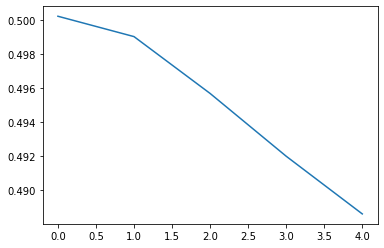

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tacc), step=1),Tacc)

validation data

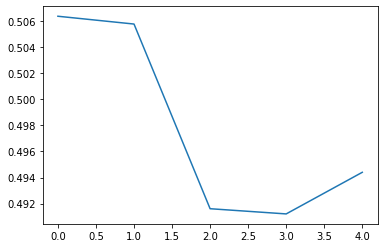

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vacc), step=1),Vacc)

That transformation is making our model not being able to determine if an image is a dog or a cat. That may be due to the black area that have been created by this transformation.

##data augmentation random rotation

In [ ]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomRotation(90),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
data augmentation random rotation

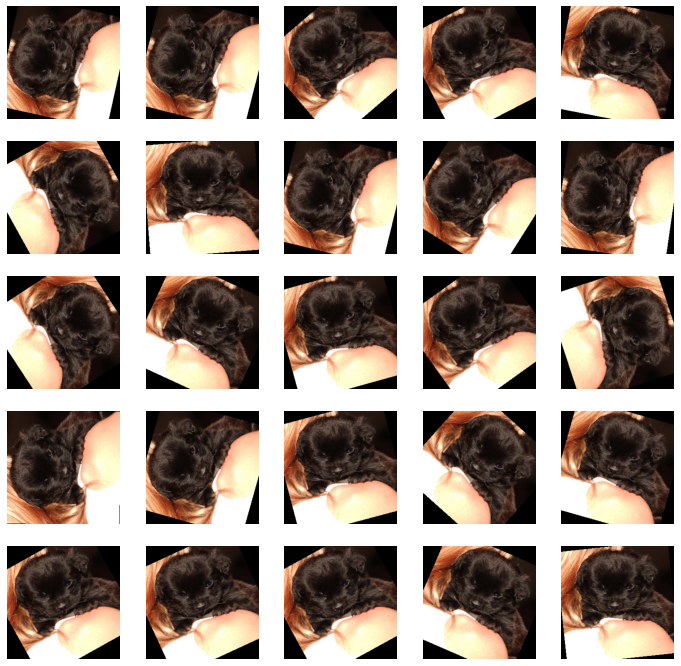

In [ ]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
ds1 = MyData(X_train, y_train, transform)
ds2 = MyData(x_val, y_val, transform)


train_ds = DataLoader(ds1, batch_size=batch_size, shuffle=True)
val_ds = DataLoader(ds2, batch_size=batch_size, shuffle=True)

In [ ]:
model =Model()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy
Tloss=[]
Tacc=[]
Tauc=[]
Vloss=[]
Vacc=[]
Vauc=[]
for epoch in range(5):
    train_loss,train_acc,train_auc=train(model, epoch, train_ds)
    Tloss.append(train_loss)
    Tauc.append(train_auc)
    Tacc.append(train_acc)
    val_loss,val_acc,val_auc=evaluate(model, val_ds)
    Vloss.append(val_loss)
    Vacc.append(val_acc)
    Vauc.append(val_auc)

epoch: 0 --> train_loss: 0.647725 - train_acc: 0.609500 - val_loss: 0.623557 - val_acc: 0.653200
epoch: 1 --> train_loss: 0.601299 - train_acc: 0.683700 - val_loss: 0.592701 - val_acc: 0.697200
epoch: 2 --> train_loss: 0.584240 - train_acc: 0.704850 - val_loss: 0.586391 - val_acc: 0.700800
epoch: 3 --> train_loss: 0.574026 - train_acc: 0.719500 - val_loss: 0.566180 - val_acc: 0.728400
epoch: 4 --> train_loss: 0.563210 - train_acc: 0.733300 - val_loss: 0.558234 - val_acc: 0.735800


**acc evolution per epoch**

train data

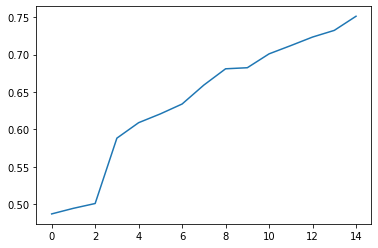

In [ ]:
plt.plot(np.arange(start=0, stop=len(Tacc), step=1),Tacc)

validation data

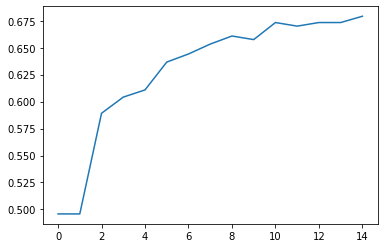

In [ ]:
plt.plot(np.arange(start=0, stop=len(Vacc), step=1),Vacc)

The random rotation has the same impact as the random crop. The accuracy is getting up with fewer epochs. Each epoch is slower due to the size of the dataset being higher.

 # conclusion about data augmentation

In conclusion the data augmentation is mostly powerful when you have a lack of data. In our case this is not very useful since our dataset is already big enough.